# Install and Import Libraries

In [12]:
!pip install yfinance gym numpy matplotlib pandas

In [13]:
import yfinance as yf
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Download Data Saham

In [14]:
stock_data = yf.download('AAPL', start='2023-01-01',end ='2024-01-01', auto_adjust=False)
stock_data.head()

[*********************100%***********************]  1 of 1 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2023-01-03,123.096024,125.070000,130.899994,124.169998,130.279999,112117500
2023-01-04,124.365662,126.360001,128.660004,125.080002,126.889999,89113600
2023-01-05,123.046799,125.019997,127.769997,124.760002,127.129997,80962700
2023-01-06,127.574203,129.619995,130.289993,124.889999,126.010002,87754700
2023-01-09,128.095856,130.149994,133.410004,129.889999,130.470001,70790800


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Data Preprocessing

In [15]:
stock_data.isnull().sum()
stock_data.fillna(method='ffill', inplace=True)

/tmp/ipython-input-597515769.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


# Create the Trading Environment with Gym
StockTradingEnv is a custom environment that simulates trading actions such as buying, selling, and holding based on stock price data.

Action Space: 0 = hold, 1 = buy, 2 = sell.

Observation Space: The environment observes the current stock price and previous position (whether the agent has bought or sold stock)

In [16]:
from numpy._core.defchararray import lower
class StockTradingEnv(gym.Env):
  def __init__(self, data):
    super(StockTradingEnv, self).__init__()
    self.data = data
    self.current_step = 0
    self.max_steps = len(data) - 1
    self.action_space = spaces.Discrete(3)
    self.observation_space = spaces.MultiDiscrete([self.max_steps + 1, 2])
    self.holding_stock = 0
    self.stock_held_price = 0.0

  def reset (self):
    self.current_step = 0
    self.holding_stock = 0
    self.stock_held_price = 0.0
    return (self.current_step, self.holding_stock)

  def step(self, action):
    current_price = self.data['Close'].iloc[self.current_step]
    reward = 0

    if action == 1: # Buy
      if self.holding_stock == 0:
        self.holding_stock = 1
        self.stock_held_price = current_price
    elif action == 2: # Sell
      if self.holding_stock == 1:
        reward = current_price - self.stock_held_price
        self.holding_stock = 0
        self.stock_held_price = 0.0


    self.current_step += 1
    done = self.current_step >= self.max_steps

    next_state = (self.current_step, self.holding_stock)

    return next_state, reward, done, {}

  def render(self):
    pass

# Q-Learning Agent Implementation
QLearningAgent stores and updates a Q-table that is used to decide which action to take at any given state based on the highest Q-value.

Exploration vs Exploitation: The agent will explore random actions at first but will start exploiting the best actions (based on learned experience) as the training progresses.

In [17]:
class QLearningAgent:
  def __init__(self, action_space,state_space, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1,exploration_decay=0.995):
    self.action_space = action_space
    self.state_space = state_space
    q_table_shape = tuple(state_space) + (action_space,)
    print(f"Initializing Q-table with shape: {q_table_shape}")
    self.q_table = np.zeros(q_table_shape)
    self.learning_rate = learning_rate
    self.discount_factor = discount_factor
    self.exploration_rate = exploration_rate
    self.exploration_decay = exploration_decay

  def choose_action(self, state):
    if np.random.rand() < self.exploration_rate:
      return np.random.choice(self.action_space)
    else:
      return np.argmax(self.q_table[state])

  def learn(self, state, action, reward, next_state, done):
      old_q_value = self.q_table[state + (action,)]
      next_max_q_value = np.max(self.q_table[next_state])
      new_q_value = old_q_value + self.learning_rate * (reward + self.discount_factor * next_max_q_value - old_q_value)
      self.q_table[state + (action,)] = new_q_value
      if done:
          self.exploration_rate *= self.exploration_decay

# Train the Q-Learning Agent

In [18]:
from os import stat_result
env = StockTradingEnv(stock_data)
agent = QLearningAgent(action_space=env.action_space.n, state_space=env.observation_space.nvec)
n_episodes = 1000
rewards_per_episode = []
for episode in range(n_episodes):
  state = env.reset()
  done = False
  total_reward = 0
  while not done:
    action = agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    agent.learn(state, action, reward, next_state, done)
    state = next_state
    total_reward += reward
  rewards_per_episode.append(total_reward)
  print(f"Episode {episode + 1}/{n_episodes}, Total Reward: {total_reward}")

/tmp/ipython-input-3060692779.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.q_table[state + (action,)] = new_q_value


Initializing Q-table with shape: (np.int64(250), np.int64(2), 3)
Episode 1/1000, Total Reward: Ticker
AAPL    0.369995
dtype: float64
Episode 2/1000, Total Reward: Ticker
AAPL    43.899994
dtype: float64
Episode 3/1000, Total Reward: Ticker
AAPL   -1.989975
dtype: float64
Episode 4/1000, Total Reward: Ticker
AAPL    20.349991
dtype: float64
Episode 5/1000, Total Reward: Ticker
AAPL    17.490005
dtype: float64
Episode 6/1000, Total Reward: Ticker
AAPL    20.579971
dtype: float64
Episode 7/1000, Total Reward: Ticker
AAPL    24.120026
dtype: float64
Episode 8/1000, Total Reward: Ticker
AAPL    12.970001
dtype: float64
Episode 9/1000, Total Reward: Ticker
AAPL    10.759995
dtype: float64
Episode 10/1000, Total Reward: Ticker
AAPL    17.62001
dtype: float64
Episode 11/1000, Total Reward: Ticker
AAPL    23.839996
dtype: float64
Episode 12/1000, Total Reward: Ticker
AAPL    30.679993
dtype: float64
Episode 13/1000, Total Reward: Ticker
AAPL    12.320023
dtype: float64
Episode 14/1000, Total R

# Evaluate the Model

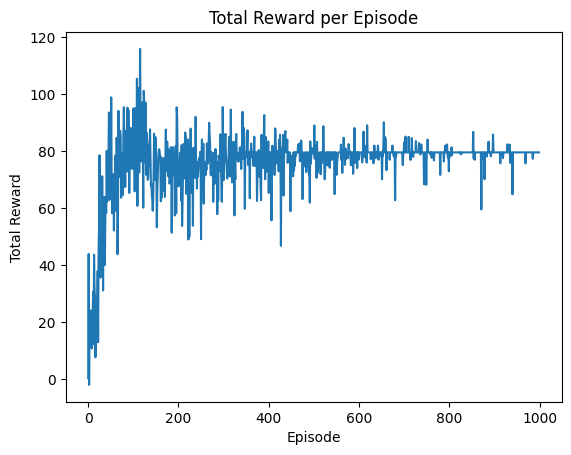

In [19]:
plt.plot(rewards_per_episode)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()